In [1]:
import numpy as np
import queries
import query_filters
import player_info
import situation_detection
import matplotlib.pyplot as plt

In [2]:
test_bombsite = situation_detection.bombsite_situation(
    filter_obj = query_filters.filter_info(match_id = '1iFV0RYkGIMFnxTpij3oLVmkLYe'))

In [3]:
test_bombsite.filter_obj

filter_info(match_id='1iFV0RYkGIMFnxTpij3oLVmkLYe', player='')

In [4]:
test_bombsite.find_bombsite_frames()

populate_bombsite_xyz

                    SELECT *
                    FROM public."resultPlayer"
                    WHERE
                        "IsInBombZone" = true
                        AND "matchID" = '1iFV0RYkGIMFnxTpij3oLVmkLYe'
find_bombsite_frames

                    SELECT
                        public."resultPlayer"."Frame" AS "Frame",
                        public."resultPlayer"."RoundNumber" AS "RoundNumber",
                        public."resultPlayer"."CurrentTime" AS "CurrentTime",
                        public."resultPlayer"."Position_X" AS "Position_X",
                        public."resultPlayer"."Position_Y" AS "Position_Y",
                        public."resultPlayer"."Position_Z" AS "Position_Z",
                        public."resultShoot"."Shooter" AS "Shooter",
                        public."resultShoot"."Weapon" AS "Weapon"
                    FROM
                        public."resultPlayer" INNER JOIN public."resultShoot"
                      

In [5]:
site1_x = (test_bombsite.bombsites[0][0][0],
           test_bombsite.bombsites[0][0][0],
           test_bombsite.bombsites[0][0][1],
           test_bombsite.bombsites[0][0][1],
           test_bombsite.bombsites[0][0][0])

site1_y = (test_bombsite.bombsites[0][1][0],
           test_bombsite.bombsites[0][1][1],
           test_bombsite.bombsites[0][1][1],
           test_bombsite.bombsites[0][1][0],
           test_bombsite.bombsites[0][1][0])

site2_x = (test_bombsite.bombsites[1][0][0],
           test_bombsite.bombsites[1][0][0],
           test_bombsite.bombsites[1][0][1],
           test_bombsite.bombsites[1][0][1],
           test_bombsite.bombsites[1][0][0])

site2_y = (test_bombsite.bombsites[1][1][0],
           test_bombsite.bombsites[1][1][1],
           test_bombsite.bombsites[1][1][1],
           test_bombsite.bombsites[1][1][0],
           test_bombsite.bombsites[1][1][0])

frame_width = 100

site1_min_X = test_bombsite.bombsites[0][0][0] - frame_width
site1_max_X = test_bombsite.bombsites[0][0][1] + frame_width
site1_min_Y = test_bombsite.bombsites[0][1][0] - frame_width
site1_max_Y = test_bombsite.bombsites[0][1][1] + frame_width

site2_min_X = test_bombsite.bombsites[1][0][0] - frame_width
site2_max_X = test_bombsite.bombsites[1][0][1] + frame_width
site2_min_Y = test_bombsite.bombsites[1][1][0] - frame_width
site2_max_Y = test_bombsite.bombsites[1][1][1] + frame_width

box1_x = (site1_min_X, site1_min_X, site1_max_X, site1_max_X, site1_min_X)
box1_y = (site1_min_Y, site1_max_Y, site1_max_Y, site1_min_Y, site1_min_Y)
box2_x = (site2_min_X, site2_min_X, site2_max_X, site2_max_X, site2_min_X)
box2_y = (site2_min_Y, site2_max_Y, site2_max_Y, site2_min_Y, site2_min_Y)

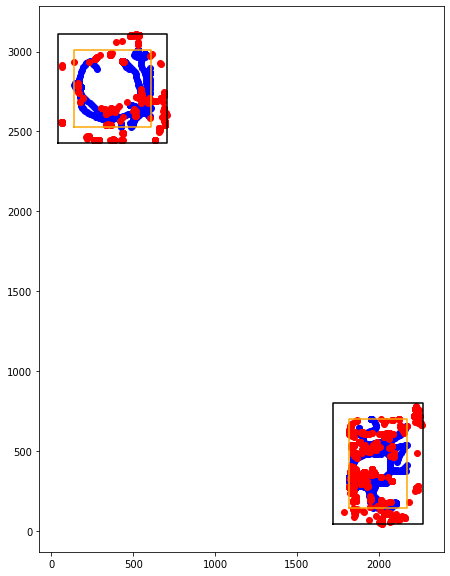

In [6]:
plt.figure(figsize=(max(test_bombsite.bombsite_xyz['Position_X'] / 300),
                    max(test_bombsite.bombsite_xyz['Position_Y'] / 300)))

# approximate box of bombsite
plt.plot(site1_x, site1_y, color='orange')
plt.plot(site2_x, site2_y, color='orange')

# approximate box considered to be shooting around bombsite
plt.plot(box1_x, box1_y, color='black')
plt.plot(box2_x, box2_y, color='black')

# all locations of players inide bombsite
plt.scatter(test_bombsite.bombsite_xyz['Position_X'],
            test_bombsite.bombsite_xyz['Position_Y'], color='blue')

# all location of players shooting inside box around bombsite
plt.scatter(test_bombsite.bomb_frames['Position_X'],
            test_bombsite.bomb_frames['Position_Y'], color='red')

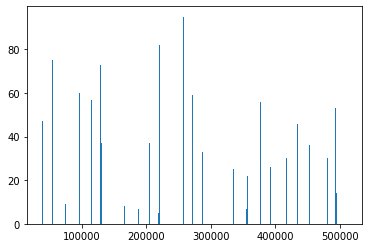

In [7]:
# x is the frame number, as expected, bombsite engagements are pretty discrete
p = plt.hist(test_bombsite.bombsite_xyz['Frame'], bins = 500)